In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Applications

In [3]:
from pyha.cores import MovingAverage
from pyha.cores.util import *

## Noise removal

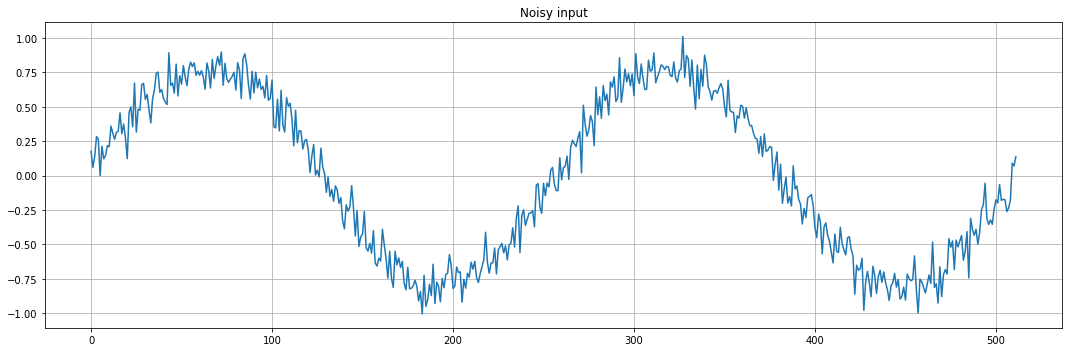

In [4]:
t = np.linspace(0,2*2*np.pi,512)
signal = 0.8*np.sin(t)
noise = 0.1*np.random.normal(size=512)
input_signal = signal +  noise
plt.title('Noisy input')
plt.plot(input_signal)
show_plot()

In [5]:
# NBVAL_IGNORE_OUTPUT
dut = MovingAverage(window_len=32)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 39262.76it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


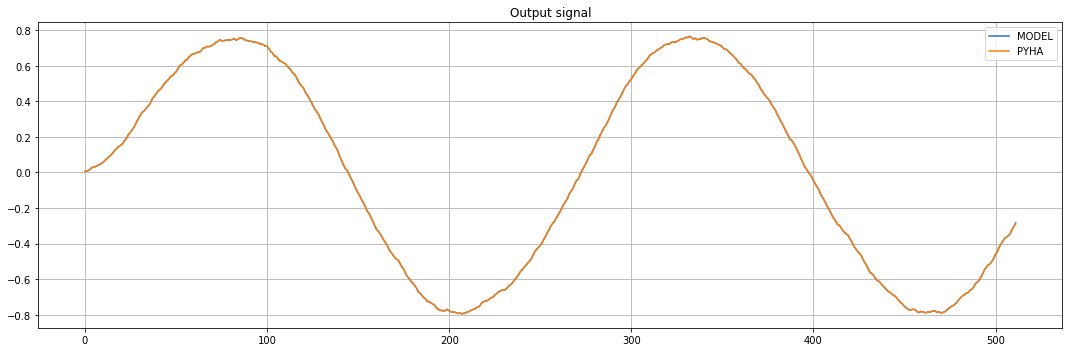

In [6]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

## Low pass filter

In [7]:
# NBVAL_IGNORE_OUTPUT
inp = [0.0] * 512
inp[0] = 1.0
dut = MovingAverage(window_len=32)
sims = simulate(dut, inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 42813.50it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


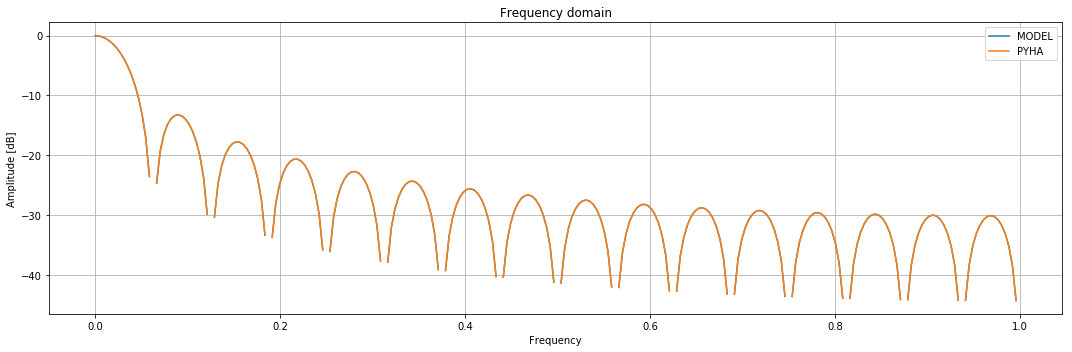

In [8]:
plt.title('Frequency domain')
gain_fix = len(inp)
for key, value in sims.items():
    plt.magnitude_spectrum(np.array(value) * gain_fix, window=plt.mlab.window_none, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

## Matched filter

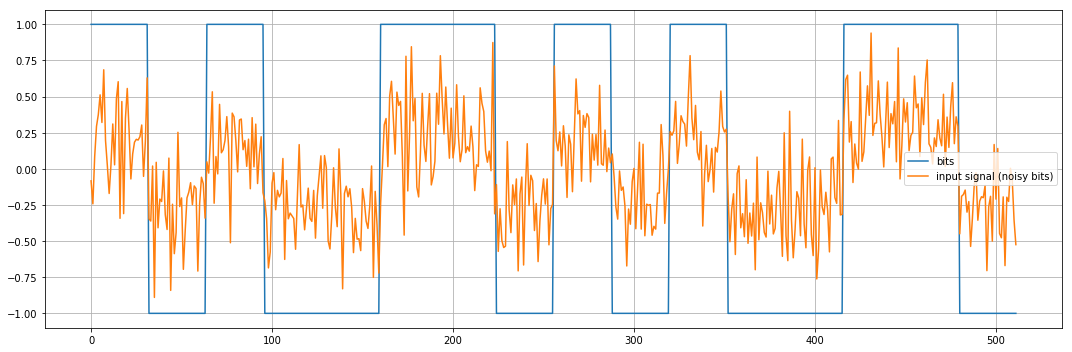

In [9]:
bits = [1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
oversample = np.array([[x] * 32 for x in bits]).flatten()
noisy = (oversample + np.random.normal(size=len(oversample))) * 0.25
plt.plot(oversample, label='bits')
plt.plot(noisy, label='input signal (noisy bits)')
show_plot()

In [10]:
# NBVAL_IGNORE_OUTPUT
dut = MovingAverage(window_len=32)
sims = simulate(dut, noisy, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 43148.33it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


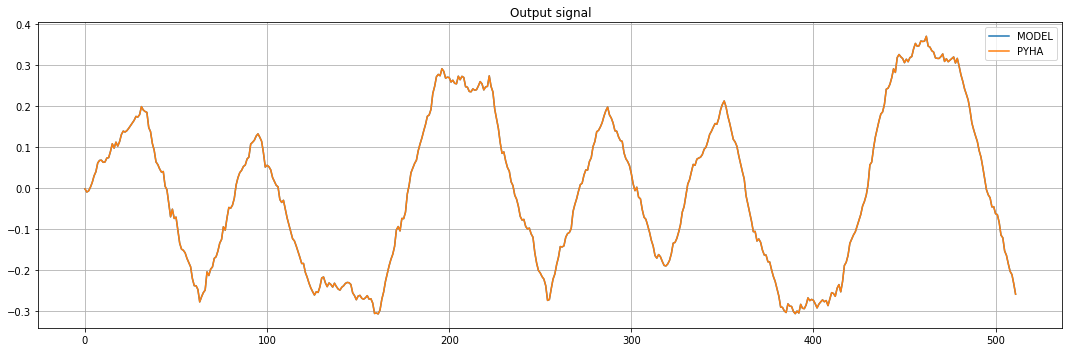

In [11]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [12]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


### Example with too small input values

In [13]:
# NBVAL_IGNORE_OUTPUT
dut = MovingAverage(window_len=32)
small_noisy = noisy *  0.0001
sims = simulate(dut, small_noisy, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 42006.09it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


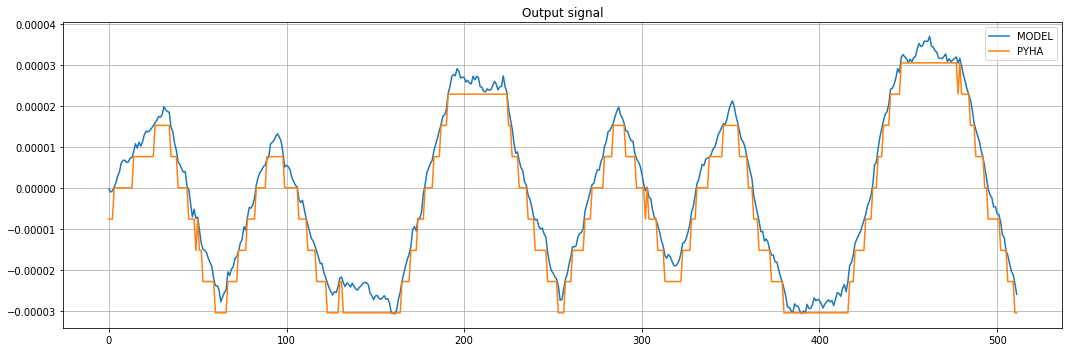

In [14]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

### Example with too large input values

In [15]:
# NBVAL_IGNORE_OUTPUT
small_noisy = noisy *  8
dut = MovingAverage(window_len=32)
sims = simulate(dut, small_noisy, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...


INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 43104.25it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


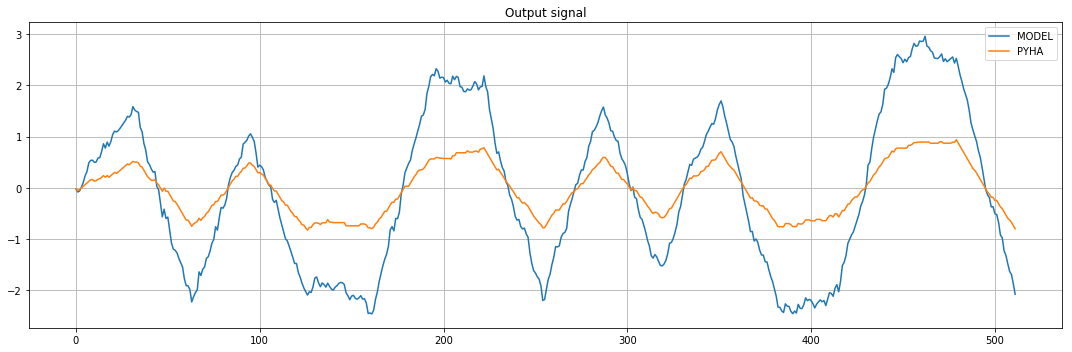

In [16]:
plt.title('Output signal')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

### Conclusion
Keep inputs in 1 .. -1 range and expect outputs in 1 .. -1 range.

# Synthesis

In [17]:
# NBVAL_IGNORE_OUTPUT
output_dir = '/tmp/pyha_output'
dut = MovingAverage(window_len=32)
sims = simulate(dut, signal, simulations=['PYHA', 'RTL', 'GATE'], conversion_path=output_dir)

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 513/513 [00:00<00:00, 10682.70it/s]

INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...


INFO:conversion:MovingAverage to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:MovingAverage to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Tue Aug 21 12:26:47 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 82
INFO:sim:    Total combinational functions : 64
INFO:sim:    Dedicated logic registers : 52
INFO:sim:Total registers : 52
INFO:sim:Total pins : 38
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 522
INFO:sim:Embedded Multiplier 9-bit elements : 0
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Simulations completed!


In [18]:
assert hardware_sims_equal(sims)

INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!
INFO:sim:RTL OK!
INFO:sim:GATE OK!


In [19]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

Logic elements: 82
Memory: 522
Multipler (18bit): 0
